# School network construction testing, debugging & visualization

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
from numpy import sin, cos, pi
import pandas as pd
from os.path import join
from importlib import reload

# network construction utilities
from scseirx import construct_school_network as csn

## Background information

In [2]:
# different age structures in Austrian school types
age_brackets = {'primary':[6, 7, 8, 9],
                'primary_dc':[6, 7, 8, 9],
                'lower_secondary':[10, 11, 12, 13],
                'lower_secondary_dc':[10, 11, 12, 13],
                'upper_secondary':[14, 15, 16, 17],
                'secondary':[10, 11, 12, 13, 14, 15, 16, 17],
                'secondary_dc':[10, 11, 12, 13, 14, 15, 16, 17]
               }

Family sizes with children < 18 years old from the [Austrian microcensus 2019](https://www.statistik.at/web_de/statistiken/menschen_und_gesellschaft/bevoelkerung/haushalte_familien_lebensformen/familien/index.html) (Note: 63.45 % of all households have no children), file ```familien_nach_familientyp_und_zahl_der_kinder_ausgewaehlter_altersgruppen_```:

* 1 child: 48.15 % (81.95 % two parents, 18.05 % single parents)
* 2 children: 38.12 % (89.70 % two parents, 10.30% single parents)
* 3 children: 10.69 % (88.26 % two parents, 11.74 % single parents)
* 4 or more children: 3.04 % (87.44 % two parents, 12.56 % single parents)

In [3]:
# given the precondition that the family has at least one child, how many
# children does the family have?
p_children = {1:0.4815, 2:0.3812, 3:0.1069, 4:0.0304}

# probability of being a single parent, depending on the number of children
p_parents = {1:{1:0.1805, 2:0.8195},
             2:{1:0.1030, 2:0.8970},
             3:{1:0.1174, 2:0.8826},
             4:{1:0.1256, 2:0.8744}
            }

General household sizes of households with one family (2.51% of households have more than one family) [Austrain household statistics 2019](https://www.statistik.at/web_de/statistiken/menschen_und_gesellschaft/bevoelkerung/haushalte_familien_lebensformen/haushalte/index.html), files 
* ```ergebnisse_im_ueberblick_privathaushalte_1985_-_2019```
* ```familien_nach_familientyp_und_zahl_der_kinder_ausgewaehlter_altersgruppen_``` 

Percentages:
* single $\frac{(3950 - 2388)}{3959}$ = 39.54 %
* couple, no kids $\frac{1001}{3959}$ = 25.28 % 
* single parent with one kid < 18: $\frac{277}{3950} \cdot \frac{87.0}{137.4}$ = 4.44 %
* single parent with two kids < 18: $\frac{277}{3950} \cdot \frac{37.3}{137.4}$ = 1.9%
* single parent with three or more kids < 18: $\frac{277}{3950} \cdot \frac{13.1}{137.4}$ = 0.67%
* couples with one kid < 18: $\frac{1050}{3950} \cdot \frac{252.4}{606.7}$ = 11.06 %
* couples with two kids < 18: $\frac{1050}{3950} \cdot \frac{255.5}{606.7}$ = 11.19 %
* couples with three or more kids <18: $\frac{1050}{3950} \cdot \frac{98.9}{606.7}$ = 4.33 % 
* households with three adults (statistic: household with  kids > 18 years): 1.59 % 

In [4]:
# probability of a household having a certain size, independent of having a child
teacher_p_adults = {1:0.4655, 2:0.5186, 3:0.0159}
teacher_p_children = {1:{0:0.8495, 1:0.0953, 2:0.0408, 3:0.0144},
                      2:{0:0.4874, 1:0.2133, 2:0.2158, 3:0.0835},
                      3:{0:1, 1:0, 2:0, 3:0}}

In [5]:
# Note: student_student_daycare overwrites student_student_intra_class and
# student_student_table_neighbour

# Note: teacher_teacher_daycare_supervision and teacher_teacher_team_teaching 
# overwrite teacher_teacher_short and teacher_teacher_long
contact_map = {
    'student_household':'close', 
    'student_student_intra_class':'far',
    'student_student_table_neighbour':'intermediate',
    'student_student_daycare':'far',
    'student_student_friends':'intermediate',
    'teacher_household':'close',
    'teacher_teacher_short':'far', 
    'teacher_teacher_long':'intermediate',
    'teacher_teacher_team_teaching':'intermediate',
    'teacher_teacher_daycare_supervision':'intermediate',
    'teaching_teacher_student':'intermediate',
    'daycare_supervision_teacher_student':'intermediate'
}

Network density scores from an [article about interactions between teachers](https://academic.oup.com/her/article/23/1/62/834723?login=true) for "socialize with outside of school" (```r_friend```) and "engage in conversation regularly" (```r_conversation```).

In [6]:
r_teacher_friend = 0.059
r_teacher_conversation = 0.255

In [7]:
# average number of classes per school type and students per class
school_characteristics = {
    # Primary schools
    # Volksschule: schools 3033, classes: 18245, students: 339382
    'primary':            {'classes':8, 'students':19},
    'primary_dc':         {'classes':8, 'students':19},
    
    # Lower secondary schools
    # Hauptschule: schools 47, classes 104, students: 1993
    # Mittelschule: schools 1131, classes: 10354, students: 205905
    # Sonderschule: schools 292, classes: 1626, students: 14815
    # Total: schools: 1470, classes: 12084, students: 222713
    'lower_secondary':    {'classes':8, 'students':18},
    'lower_secondary_dc': {'classes':8, 'students':18},
    
    # Upper secondary schools
    # Oberstufenrealgymnasium: schools 114, classes 1183, students: 26211
    # BMHS: schools 734, classes 8042, students 187592
    # Total: schools: 848, classes 9225, students: 213803
    'upper_secondary':    {'classes':10, 'students':23}, # rounded down from 10.8 classes
    
    # Secondary schools
    # AHS Langform: schools 281, classes 7610, students 179633
    'secondary':          {'classes':28, 'students':24}, # rounded up from 27.1 classes
    'secondary_dc':       {'classes':28, 'students':24} # rounded up from 27.1 classes
}

## Visualization

In [8]:
def get_xy(r, phi, offset=(0, 0)):
    return r * sin(phi) + offset[0], r * cos(phi) + offset[1]

In [9]:
def calculate_agent_positions(school_type, school_characteristics):
    teacher_radii = {'primary':1.6, 'primary_dc':1.6,
                     'lower_secondary':1.6, 'lower_secondary_dc':1.6,
                     'secondary':2}
    student_radii = {'primary':1.4, 'primary_dc':1.4,
                     'lower_secondary':1.4, 'lower_secondary_dc':1.4,
                     'secondary':0.5}
    class_distance = 5
    
    N_classes = school_characteristics[school_type]['classes']
    N_teachers = csn.get_N_teachers(school_type, N_classes)

    teacher_radius = teacher_radii[school_type]
    student_radius = student_radii[school_type]

    teacher_pos = [get_xy(teacher_radius, phi) for phi in \
                   np.arange(0, 2 * pi, 2 * pi / N_teachers)]

    class_centers = [get_xy(class_distance, phi) for phi \
                     in np.arange(0, 2 * pi, 2 * pi / N_classes)]

    student_pos = []
    for c in range(1, N_classes + 1):
        student_pos.extend([get_xy(student_radius, phi, offset=class_centers[c - 1])\
                          for phi in np.arange(0, 2 * pi, 2 * pi / class_size)])

    fixed_pos = {}
    for t in range(1, N_teachers + 1):
        fixed_pos['t{:04d}'.format(t)] = teacher_pos[t - 1]

    for s in range(1, N_classes * class_size + 1):
        fixed_pos['s{:04d}'.format(s)] = student_pos[s - 1]
        
    return fixed_pos

In [10]:
colors = {'student':'#C0392B',
          'teacher':'#341F9A',
          'family_member':'grey',
          'teaching_teacher_student':'#651EA6',
          'daycare_supervision_teacher_student':'#A61EA3',
          'student_student_table_neighbour':'#C0392B',
          'student_student_intra_class':'#C05E2B',
          'student_student_daycare':'#C0842B',
          'student_student_friends':'#C05E2B',
          'teacher_teacher_short':'#1F9A90',
          'teacher_teacher_long':'#1F679A',
          'teacher_teacher_team_teaching':'#341F9A',
          'teacher_teacher_daycare_supervision':'#341F9A',
          'siblings':'#C0392B',
          'student_household':'grey',
          'teacher_household':'grey'}

thin = 0.02
intermediate = 0.5
thick = 1
widths = {'teaching_teacher_student':thin,
          'daycare_supervision_teacher_student':thin,
          'student_student_intra_class':thin,
          'student_student_table_neighbour':thick,
          'student_student_daycare':thin,
          'student_student_friends':thick,
          'teacher_teacher_short':thin,
          'teacher_teacher_long':thick,
          'teacher_teacher_team_teaching':thick,
          'teacher_teacher_daycare_supervision':thick,
          'siblings':thick,
          'student_household':thin,
          'teacher_household':thin}

labels = {
    'daycare_supervision_teacher_student':'daycare supervision',
    'teaching_teacher_student':'teaching',
    'student_student_intra_class':'classmates',
    'student_student_table_neighbour':'table neighbours &\nsiblings',
    'student_student_daycare':'daycare mates',
    'student_student_friends':'friends',
    'teacher_teacher_short':'conversation',
    'teacher_teacher_long':'acquaintances',
    'teacher_teacher_team_teaching':'joint teaching &\nsupervision',
    'teacher_teacher_daycare_supervision':'joint teaching &\nsupervision',
    'siblings':'table neighbours &\nsiblings',
    'student_household':'shared household',
    'teacher_household':'shared household'
}

### Single graph

In [11]:
reload(csn)
# architecture
N_floors = 1
# school type
school_type = 'lower_secondary'
N_classes = school_characteristics[school_type]['classes']
class_size = school_characteristics[school_type]['students']
age_bracket = csn.get_age_bracket(school_type)
half_classes = False
reduced_class_size = False
between_class_contacts = False

In [12]:
reload(csn)
from networkx import NetworkXError
save = False

MG, teacher_schedule, student_schedule = csn.compose_school_graph(school_type,
        N_classes, class_size, N_floors, p_children, p_parents, teacher_p_adults,
        teacher_p_children, r_teacher_conversation, r_teacher_friend)

if between_class_contacts:
    csn.add_between_class_contacts(0.2, class_size, N_classes, MG)
    
csn.map_contacts(MG, contact_map)

node_list = csn.get_node_list(MG)

if reduced_class_size:
    csn.reduce_class_size(reduced_class_size, class_size, N_classes, MG, student_schedule)

if half_classes:
    half = '_half'
    csn.make_half_classes(class_size, N_classes, MG, student_schedule)


In [13]:
fixed_pos = calculate_agent_positions(school_type, school_characteristics)

students = node_list[node_list['type'] == 'student']['ID'].values
teachers = node_list[node_list['type'] == 'teacher']['ID'].values
family_members = node_list[node_list['type'] == 'family_member']['ID'].values

weekday = 1
edges = MG.edges(keys=True, data='weekday')
edges = [(u, v, k) for (u, v, k, wd) in edges if wd == weekday]
G = MG.edge_subgraph(edges).copy()

for t in teachers:
    if not t in G.nodes():
        G.add_node(t)

# generate random positions for family members (students & teachers are fixed)
pos = nx.spring_layout(G, pos=fixed_pos, fixed=fixed_pos.keys())

node_color = [colors['student']] * len(students)
node_color.extend([colors['teacher']] * len(teachers))
node_color.extend([colors['family_member']] * len(family_members))

all_nodes = list(students)
all_nodes.extend(list(teachers))
all_nodes.extend(list(family_members))

### Only student & teacher nodes

In [14]:
dst = '../../plots/contact_networks/'

<ipython-input-15-a6ffb9ab5d5d>:37: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  plt.savefig(join(dst,'{}_circular_visualization_1.pdf'.format(school_type)))
<ipython-input-15-a6ffb9ab5d5d>:37: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  plt.savefig(join(dst,'{}_circular_visualization_1.pdf'.format(school_type)))
<ipython-input-15-a6ffb9ab5d5d>:38: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  plt.savefig(join(dst,'{}_circular_visualization_1.svg'.format(school_type)))
/home/jana/anaconda3/envs/covid/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


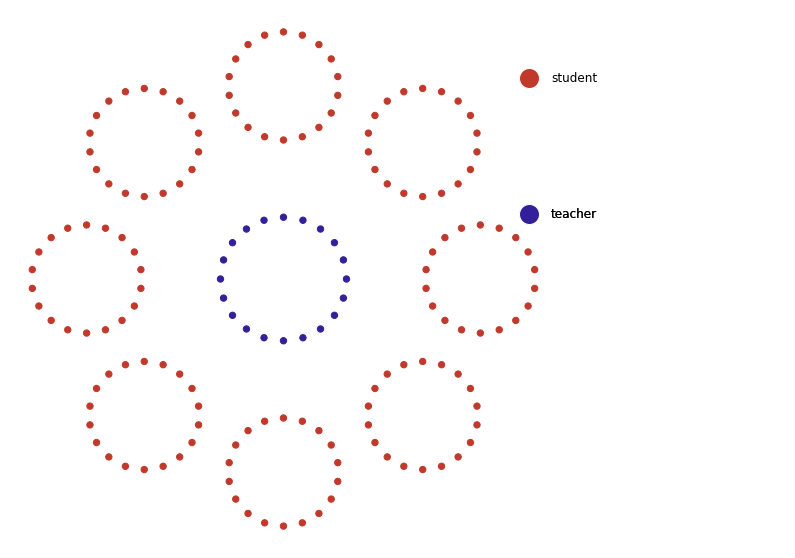

In [15]:
fig = plt.figure(constrained_layout=True, figsize=(14, 10))
gs = fig.add_gridspec(1, 7)
ax = fig.add_subplot(gs[0, 0:5])
ax2 = fig.add_subplot(gs[0, 5:])
ax2.set_axis_off()

student_lts = ['siblings',
               'student_student_table_neighbour',
               'student_student_intra_class',
               'student_student_daycare']

nx.draw(G, pos, node_size=40, ax=ax, width = 0, nodelist=list(students) + list(teachers), \
       node_color = [colors['student']] * len(students) + [colors['teacher']] * len(teachers))

legend_fontsize = 12
labelspacing = 1.2
# student <-> student link legend
student_marker = Line2D([0], [0], marker='o', color='w',
                      markerfacecolor=colors['student'], markersize=20,
                      label='student')
         
leg1 = ax.legend(handles=[student_marker], 
          labelspacing=labelspacing, loc='upper right', frameon=False,
          bbox_to_anchor=(1.087, 0.9), fontsize=legend_fontsize)

teacher_marker = Line2D([0], [0], marker='o', color='w',
                      markerfacecolor=colors['teacher'], markersize=20,
                      label='teacher')

leg3 = ax.legend(handles = [teacher_marker], 
          labelspacing=labelspacing, loc='upper right', frameon=False,
          bbox_to_anchor=(1.087, 0.65), fontsize=legend_fontsize)

for leg in [leg1, leg3]:
    ax.add_artist(leg)

plt.savefig(join(dst,'{}_circular_visualization_1.pdf'.format(school_type)))
plt.savefig(join(dst,'{}_circular_visualization_1.svg'.format(school_type)))

### + student edges

<ipython-input-16-cd18ba37e7cd>:59: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  plt.savefig(join(dst,'{}_circular_visualization_2.pdf'.format(school_type)))
<ipython-input-16-cd18ba37e7cd>:59: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  plt.savefig(join(dst,'{}_circular_visualization_2.pdf'.format(school_type)))
<ipython-input-16-cd18ba37e7cd>:60: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  plt.savefig(join(dst,'{}_circular_visualization_2.svg'.format(school_type)))
/home/jana/anaconda3/envs/covid/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


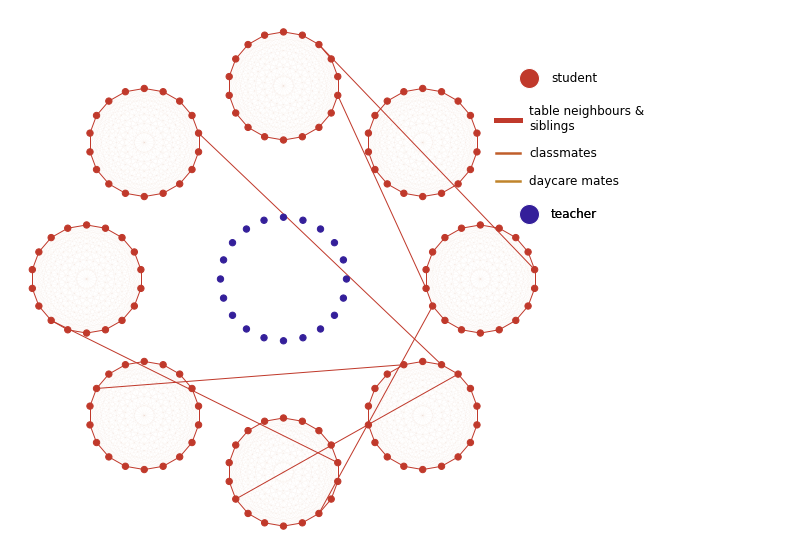

In [16]:
fig = plt.figure(constrained_layout=True, figsize=(14, 10))
gs = fig.add_gridspec(1, 7)
ax = fig.add_subplot(gs[0, 0:5])
ax2 = fig.add_subplot(gs[0, 5:])
ax2.set_axis_off()

student_lts = ['siblings',
               'student_student_table_neighbour',
               'student_student_intra_class',
               'student_student_daycare']

nx.draw(G, pos, node_size=40, ax=ax, width = 0, nodelist=list(students) + list(teachers), \
       node_color = [colors['student']] * len(students) + [colors['teacher']] * len(teachers))

for lt in student_lts:
    edgelist = [(u, v) for u, v, e in G.edges(data=True) if e['link_type'] == lt]
    nx.draw_networkx_edges(G, pos, edgelist, ax=ax, width=widths[lt],
                           edge_color=colors[lt], label=labels[lt])

# family links
lt = 'siblings'
edgelist = [(u, v) for u, v, e in G.edges(data=True) if \
                    e['contact_type'] == 'close' and \
                    G.nodes[u]['type'] == 'student' and \
                    G.nodes[v]['type'] == 'student']
nx.draw_networkx_edges(G, pos, edgelist, ax=ax, width=1, edge_color=colors[lt],
                       label=labels[lt])


legend_fontsize = 12
labelspacing = 1.2
# student <-> student link legend
student_marker = Line2D([0], [0], marker='o', color='w',
                      markerfacecolor=colors['student'], markersize=20,
                      label='student')
         

student_lines = [Line2D([0],[0], color=colors[lt], lw=w, label=labels[lt])\
                 for lt, w in zip(student_lts[1:], [5, 2.5, 2.5])]

leg1 = ax.legend(handles = [student_marker], 
          labelspacing=labelspacing, loc='upper right', frameon=False,
          bbox_to_anchor=(1.087, 0.9), fontsize=legend_fontsize)
leg2 = ax.legend(handles = student_lines, 
          labelspacing=labelspacing, loc='upper right', frameon=False,
          bbox_to_anchor=(1.173, 0.84), fontsize=legend_fontsize)

teacher_marker = Line2D([0], [0], marker='o', color='w',
                      markerfacecolor=colors['teacher'], markersize=20,
                      label='teacher')

leg3 = ax.legend(handles = [teacher_marker], 
          labelspacing=labelspacing, loc='upper right', frameon=False,
          bbox_to_anchor=(1.087, 0.65), fontsize=legend_fontsize)

for leg in [leg1, leg2, leg3]:
    ax.add_artist(leg)

plt.savefig(join(dst,'{}_circular_visualization_2.pdf'.format(school_type)))
plt.savefig(join(dst,'{}_circular_visualization_2.svg'.format(school_type)))

### + teacher edges

<ipython-input-17-d5b68cf5487c>:73: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  plt.savefig(join(dst,'{}_circular_visualization_3.pdf'.format(school_type)))
<ipython-input-17-d5b68cf5487c>:73: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  plt.savefig(join(dst,'{}_circular_visualization_3.pdf'.format(school_type)))
<ipython-input-17-d5b68cf5487c>:74: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  plt.savefig(join(dst,'{}_circular_visualization_3.svg'.format(school_type)))
/home/jana/anaconda3/envs/covid/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


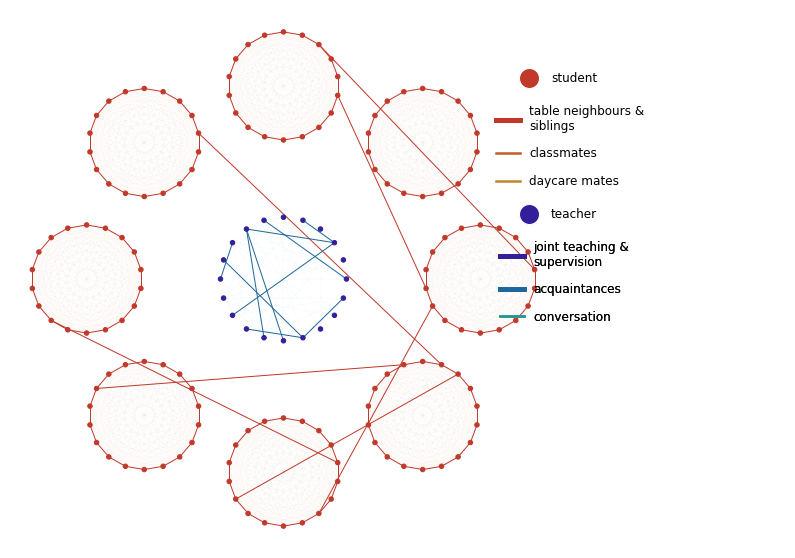

In [17]:
fig = plt.figure(constrained_layout=True, figsize=(14, 10))
gs = fig.add_gridspec(1, 7)
ax = fig.add_subplot(gs[0, 0:5])
ax2 = fig.add_subplot(gs[0, 5:])
ax2.set_axis_off()

student_lts = ['siblings',
               'student_student_table_neighbour',
               'student_student_intra_class',
               'student_student_daycare']

nx.draw(G, pos, node_size=20, ax=ax, width = 0, nodelist=list(students) + list(teachers), \
       node_color = [colors['student']] * len(students) + [colors['teacher']] * len(teachers))

for lt in student_lts:
    edgelist = [(u, v) for u, v, e in G.edges(data=True) if e['link_type'] == lt]
    nx.draw_networkx_edges(G, pos, edgelist, ax=ax, width=widths[lt],
                           edge_color=colors[lt], label=labels[lt])

# family links
lt = 'siblings'
edgelist = [(u, v) for u, v, e in G.edges(data=True) if \
                    e['contact_type'] == 'close' and \
                    G.nodes[u]['type'] == 'student' and \
                    G.nodes[v]['type'] == 'student']
nx.draw_networkx_edges(G, pos, edgelist, ax=ax, width=1, edge_color=colors[lt],
                       label=labels[lt])


legend_fontsize = 12
labelspacing = 1.2
# student <-> student link legend
student_marker = Line2D([0], [0], marker='o', color='w',
                      markerfacecolor=colors['student'], markersize=20,
                      label='student')
         

student_lines = [Line2D([0],[0], color=colors[lt], lw=w, label=labels[lt])\
                 for lt, w in zip(student_lts[1:], [5, 2.5, 2.5])]

leg1 = ax.legend(handles = [student_marker], 
          labelspacing=labelspacing, loc='upper right', frameon=False,
          bbox_to_anchor=(1.087, 0.9), fontsize=legend_fontsize)
leg2 = ax.legend(handles = student_lines, 
          labelspacing=labelspacing, loc='upper right', frameon=False,
          bbox_to_anchor=(1.173, 0.84), fontsize=legend_fontsize)

teacher_marker = Line2D([0], [0], marker='o', color='w',
                      markerfacecolor=colors['teacher'], markersize=20,
                      label='teacher')

teacher_lts = ['teacher_teacher_daycare_supervision',
               'teacher_teacher_long',
               'teacher_teacher_short']
teacher_lines = [Line2D([0],[0], color=colors[lt], lw=w, label=labels[lt])\
                 for lt, w in zip(teacher_lts, [5, 5, 2.5])]

for lt in teacher_lts:
    edgelist = [(u, v) for u, v, e in G.edges(data=True) if e['link_type'] == lt]
    nx.draw_networkx_edges(G, pos, edgelist, ax=ax, width=widths[lt],
                           edge_color=colors[lt], label=labels[lt])

leg3 = ax.legend(handles = [teacher_marker], 
          labelspacing=labelspacing, loc='upper right', frameon=False,
          bbox_to_anchor=(1.087, 0.65), fontsize=legend_fontsize)
leg4 = ax.legend(handles = teacher_lines, 
          labelspacing=labelspacing, loc='upper right', frameon=False,
          bbox_to_anchor=(1.145, 0.59), fontsize=legend_fontsize)

for leg in [leg1, leg2, leg3, leg4]:
    ax.add_artist(leg)

plt.savefig(join(dst,'{}_circular_visualization_3.pdf'.format(school_type)))
plt.savefig(join(dst,'{}_circular_visualization_3.svg'.format(school_type)))

### + teacher <-> student edges

<ipython-input-18-850b5d956a6c>:86: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  plt.savefig(join(dst,'{}_circular_visualization_4.pdf'.format(school_type)))
<ipython-input-18-850b5d956a6c>:86: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  plt.savefig(join(dst,'{}_circular_visualization_4.pdf'.format(school_type)))
<ipython-input-18-850b5d956a6c>:87: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  plt.savefig(join(dst,'{}_circular_visualization_4.svg'.format(school_type)))
/home/jana/anaconda3/envs/covid/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


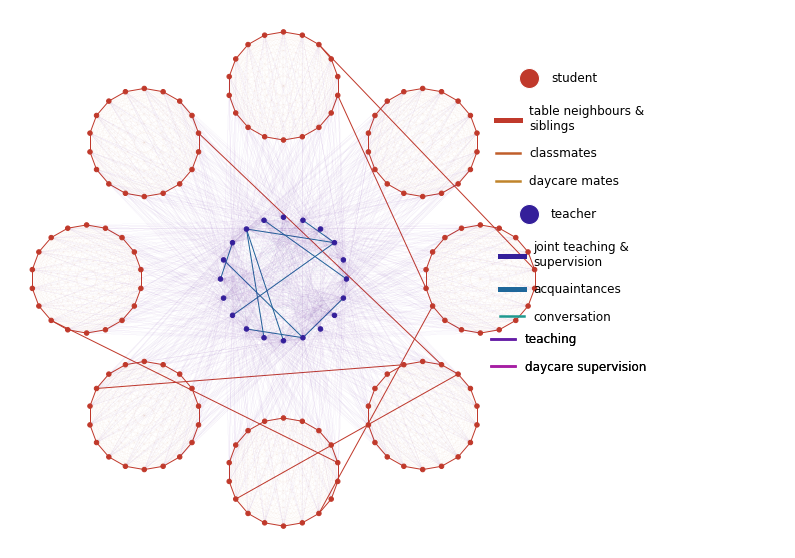

In [18]:
fig = plt.figure(constrained_layout=True, figsize=(14, 10))
gs = fig.add_gridspec(1, 7)
ax = fig.add_subplot(gs[0, 0:5])
ax2 = fig.add_subplot(gs[0, 5:])
ax2.set_axis_off()

student_lts = ['siblings',
               'student_student_table_neighbour',
               'student_student_intra_class',
               'student_student_daycare']

nx.draw(G, pos, node_size=20, ax=ax, width = 0, nodelist=list(students) + list(teachers), \
       node_color = [colors['student']] * len(students) + [colors['teacher']] * len(teachers))

for lt in student_lts:
    edgelist = [(u, v) for u, v, e in G.edges(data=True) if e['link_type'] == lt]
    nx.draw_networkx_edges(G, pos, edgelist, ax=ax, width=widths[lt],
                           edge_color=colors[lt], label=labels[lt])

# family links
lt = 'siblings'
edgelist = [(u, v) for u, v, e in G.edges(data=True) if \
                    e['contact_type'] == 'close' and \
                    G.nodes[u]['type'] == 'student' and \
                    G.nodes[v]['type'] == 'student']
nx.draw_networkx_edges(G, pos, edgelist, ax=ax, width=1, edge_color=colors[lt],
                       label=labels[lt])


legend_fontsize = 12
labelspacing = 1.2
# student <-> student link legend
student_marker = Line2D([0], [0], marker='o', color='w',
                      markerfacecolor=colors['student'], markersize=20,
                      label='student')
         

student_lines = [Line2D([0],[0], color=colors[lt], lw=w, label=labels[lt])\
                 for lt, w in zip(student_lts[1:], [5, 2.5, 2.5])]

leg1 = ax.legend(handles = [student_marker], 
          labelspacing=labelspacing, loc='upper right', frameon=False,
          bbox_to_anchor=(1.087, 0.9), fontsize=legend_fontsize)
leg2 = ax.legend(handles = student_lines, 
          labelspacing=labelspacing, loc='upper right', frameon=False,
          bbox_to_anchor=(1.173, 0.84), fontsize=legend_fontsize)

teacher_marker = Line2D([0], [0], marker='o', color='w',
                      markerfacecolor=colors['teacher'], markersize=20,
                      label='teacher')

teacher_lts = ['teacher_teacher_daycare_supervision',
               'teacher_teacher_long',
               'teacher_teacher_short']
teacher_lines = [Line2D([0],[0], color=colors[lt], lw=w, label=labels[lt])\
                 for lt, w in zip(teacher_lts, [5, 5, 2.5])]

for lt in teacher_lts:
    edgelist = [(u, v) for u, v, e in G.edges(data=True) if e['link_type'] == lt]
    nx.draw_networkx_edges(G, pos, edgelist, ax=ax, width=widths[lt],
                           edge_color=colors[lt], label=labels[lt])

leg3 = ax.legend(handles = [teacher_marker], 
          labelspacing=labelspacing, loc='upper right', frameon=False,
          bbox_to_anchor=(1.087, 0.65), fontsize=legend_fontsize)
leg4 = ax.legend(handles = teacher_lines, 
          labelspacing=labelspacing, loc='upper right', frameon=False,
          bbox_to_anchor=(1.145, 0.59), fontsize=legend_fontsize)

# teacher <-> student links
ts_lts = ['teaching_teacher_student',
          'daycare_supervision_teacher_student']
for lt in ts_lts:
    edgelist = [(u, v) for u, v, e in G.edges(data=True) if e['link_type'] == lt]
    nx.draw_networkx_edges(G, pos, edgelist, ax=ax, width=widths[lt],
                           edge_color=colors[lt], label=labels[lt])
ts_lines = [Line2D([0],[0], color=colors[lt], lw=w, label=labels[lt])\
                 for lt, w in zip(ts_lts, [2.5, 2.5])]
leg5 = ax.legend(handles = ts_lines, 
          labelspacing=labelspacing, loc='upper right', frameon=False,
          bbox_to_anchor=(1.176, 0.42), fontsize=legend_fontsize)

for leg in [leg1, leg2, leg3, leg4, leg5]:
    ax.add_artist(leg)

plt.savefig(join(dst,'{}_circular_visualization_4.pdf'.format(school_type)))
plt.savefig(join(dst,'{}_circular_visualization_4.svg'.format(school_type)))

<ipython-input-19-bbe1af78db7e>:102: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  plt.savefig(join(dst,'{}_circular_visualization_5.pdf'.format(school_type)))
<ipython-input-19-bbe1af78db7e>:102: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  plt.savefig(join(dst,'{}_circular_visualization_5.pdf'.format(school_type)))
<ipython-input-19-bbe1af78db7e>:103: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  plt.savefig(join(dst,'{}_circular_visualization_5.svg'.format(school_type)))
/home/jana/anaconda3/envs/covid/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


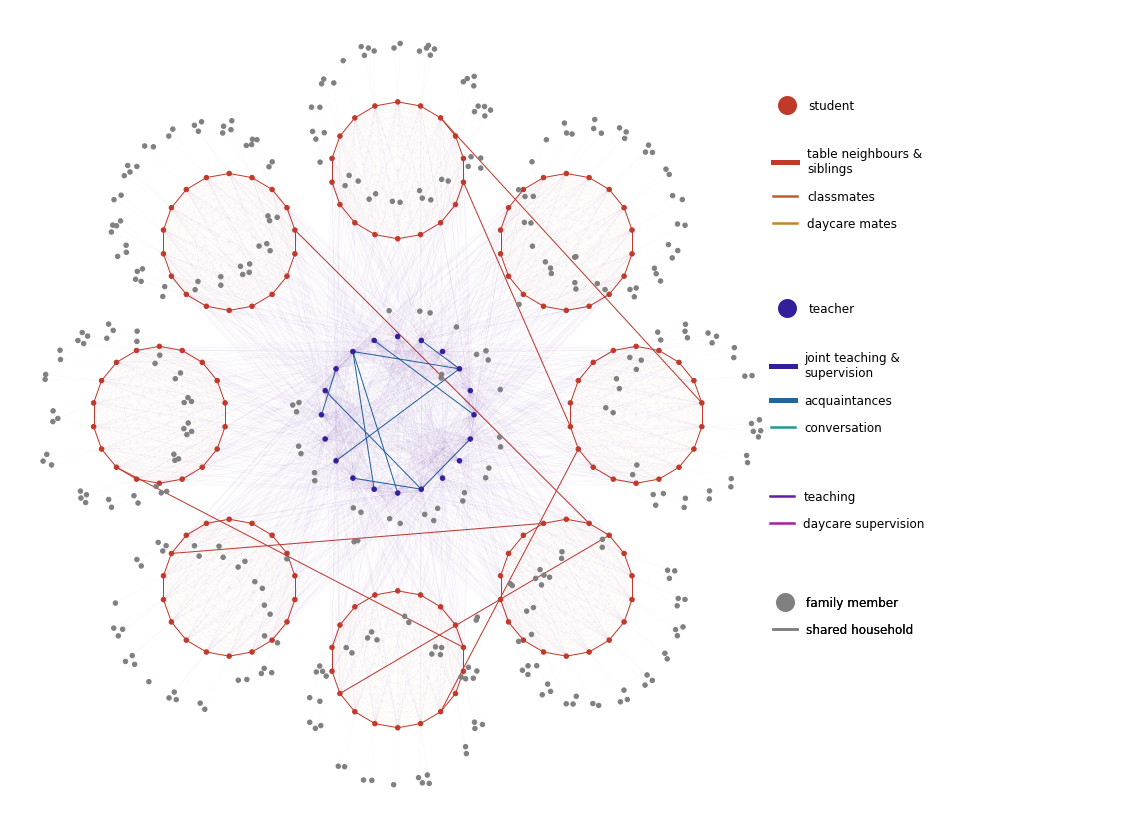

In [19]:
fig = plt.figure(constrained_layout=True, figsize=(20, 15))
gs = fig.add_gridspec(1, 7)
ax = fig.add_subplot(gs[0, 0:5])
ax2 = fig.add_subplot(gs[0, 5:])
ax2.set_axis_off()

student_lts = ['siblings',
               'student_student_table_neighbour',
               'student_student_intra_class',
               'student_student_daycare']

nx.draw(G, pos, node_size=20, ax=ax, width = 0, nodelist=all_nodes, \
       node_color = node_color)

for lt in student_lts:
    edgelist = [(u, v) for u, v, e in G.edges(data=True) if e['link_type'] == lt]
    nx.draw_networkx_edges(G, pos, edgelist, ax=ax, width=widths[lt],
                           edge_color=colors[lt], label=labels[lt])

# family links
lt = 'siblings'
edgelist = [(u, v) for u, v, e in G.edges(data=True) if \
                    e['contact_type'] == 'close' and \
                    G.nodes[u]['type'] == 'student' and \
                    G.nodes[v]['type'] == 'student']
nx.draw_networkx_edges(G, pos, edgelist, ax=ax, width=1, edge_color=colors[lt],
                       label=labels[lt])


legend_fontsize = 12
labelspacing = 1.2
# student <-> student link legend
student_marker = Line2D([0], [0], marker='o', color='w',
                      markerfacecolor=colors['student'], markersize=20,
                      label='student')
         

student_lines = [Line2D([0],[0], color=colors[lt], lw=w, label=labels[lt])\
                 for lt, w in zip(student_lts[1:], [5, 2.5, 2.5])]

leg1 = ax.legend(handles = [student_marker], 
          labelspacing=labelspacing, loc='upper right', frameon=False,
          bbox_to_anchor=(1.087, 0.9), fontsize=legend_fontsize)
leg2 = ax.legend(handles = student_lines, 
          labelspacing=labelspacing, loc='upper right', frameon=False,
          bbox_to_anchor=(1.173, 0.84), fontsize=legend_fontsize)

teacher_marker = Line2D([0], [0], marker='o', color='w',
                      markerfacecolor=colors['teacher'], markersize=20,
                      label='teacher')

teacher_lts = ['teacher_teacher_daycare_supervision',
               'teacher_teacher_long',
               'teacher_teacher_short']
teacher_lines = [Line2D([0],[0], color=colors[lt], lw=w, label=labels[lt])\
                 for lt, w in zip(teacher_lts, [5, 5, 2.5])]

for lt in teacher_lts:
    edgelist = [(u, v) for u, v, e in G.edges(data=True) if e['link_type'] == lt]
    nx.draw_networkx_edges(G, pos, edgelist, ax=ax, width=widths[lt],
                           edge_color=colors[lt], label=labels[lt])

leg3 = ax.legend(handles = [teacher_marker], 
          labelspacing=labelspacing, loc='upper right', frameon=False,
          bbox_to_anchor=(1.087, 0.65), fontsize=legend_fontsize)
leg4 = ax.legend(handles = teacher_lines, 
          labelspacing=labelspacing, loc='upper right', frameon=False,
          bbox_to_anchor=(1.145, 0.59), fontsize=legend_fontsize)

# teacher <-> student links
ts_lts = ['teaching_teacher_student',
          'daycare_supervision_teacher_student']
for lt in ts_lts:
    edgelist = [(u, v) for u, v, e in G.edges(data=True) if e['link_type'] == lt]
    nx.draw_networkx_edges(G, pos, edgelist, ax=ax, width=widths[lt],
                           edge_color=colors[lt], label=labels[lt])
ts_lines = [Line2D([0],[0], color=colors[lt], lw=w, label=labels[lt])\
                 for lt, w in zip(ts_lts, [2.5, 2.5])]
leg5 = ax.legend(handles = ts_lines, 
          labelspacing=labelspacing, loc='upper right', frameon=False,
          bbox_to_anchor=(1.176, 0.42), fontsize=legend_fontsize)

# family member
family_marker = Line2D([0], [0], marker='o', color='w',
                      markerfacecolor=colors['family_member'], markersize=20,
                      label='family member')
family_lts = ['student_household', 'teacher_household']
for lt in family_lts:
    edgelist = [(u, v) for u, v, e in G.edges(data=True) if e['link_type'] == lt]
    nx.draw_networkx_edges(G, pos, edgelist, ax=ax, width=widths[lt],
                           edge_color=colors[lt], label=labels[lt])
    
family_lines = [Line2D([0],[0], color=colors[lt], lw=w, label=labels[lt])\
                 for lt, w in zip(family_lts, [2.5])]
leg6 = ax.legend(handles = [family_marker] + family_lines,
          labelspacing=labelspacing, loc='upper right', frameon=False,
          bbox_to_anchor=(1.162, 0.29), fontsize=legend_fontsize)

for leg in [leg1, leg2, leg3, leg4, leg5, leg6]:
    ax.add_artist(leg)

plt.savefig(join(dst,'{}_circular_visualization_5.pdf'.format(school_type)))
plt.savefig(join(dst,'{}_circular_visualization_5.svg'.format(school_type)))

## Two networks next to each other

In [28]:
dst = '../../plots/contact_networks/'

In [29]:
N_floors = 1
weekday = 1

In [30]:
csn.get_N_teachers('primary_dc', 8)

16

In [31]:
csn.get_N_teachers('secondary', 28)

70

In [32]:
# primary school with daycare
school_type = 'primary_dc'
N_classes = school_characteristics[school_type]['classes']
class_size = school_characteristics[school_type]['students']
age_bracket = csn.get_age_bracket(school_type)

MG_primary_dc, teacher_schedule_primary_dc, student_schedule_primary_dc = \
        csn.compose_school_graph(school_type,
        N_classes, class_size, N_floors, p_children, p_parents, teacher_p_adults,
        teacher_p_children, r_teacher_conversation, r_teacher_friend)
    
csn.map_contacts(MG_primary_dc, contact_map)
node_list_primary_dc = csn.get_node_list(MG_primary_dc)

fixed_pos_primary_dc = calculate_agent_positions(school_type, school_characteristics)
edges = MG_primary_dc.edges(keys=True, data='weekday')
edges = [(u, v, k) for (u, v, k, wd) in edges if wd == weekday]
G_primary_dc = MG_primary_dc.edge_subgraph(edges).copy()

teachers = node_list_primary_dc[node_list_primary_dc['type'] == 'teacher']['ID'].values
for t in teachers:
    if not t in G_primary_dc.nodes():
        G_primary_dc.add_node(t)

# generate random positions for family members (students & teachers are fixed)
pos_primary_dc = nx.spring_layout(G_primary_dc, pos=fixed_pos_primary_dc, fixed=fixed_pos_primary_dc.keys())

In [33]:
# secondary school
school_type = 'secondary'
N_classes = school_characteristics[school_type]['classes']
class_size = school_characteristics[school_type]['students']
age_bracket = csn.get_age_bracket(school_type)

MG_secondary, teacher_schedule_secondary, student_schedule_secondary = \
        csn.compose_school_graph(school_type,
        N_classes, class_size, N_floors, p_children, p_parents, teacher_p_adults,
        teacher_p_children, r_teacher_conversation, r_teacher_friend)
    
csn.map_contacts(MG_secondary, contact_map)
node_list_secondary = csn.get_node_list(MG_secondary)

fixed_pos_secondary = calculate_agent_positions(school_type, school_characteristics)
edges = MG_secondary.edges(keys=True, data='weekday')
edges = [(u, v, k) for (u, v, k, wd) in edges if wd == weekday]
G_secondary = MG_secondary.edge_subgraph(edges).copy()

teachers = node_list_secondary[node_list_secondary['type'] == 'teacher']['ID'].values
for t in teachers:
    if not t in G_secondary.nodes():
        G_secondary.add_node(t)

# generate random positions for family members (students & teachers are fixed)
pos_secondary = nx.spring_layout(G_secondary, pos=fixed_pos_secondary, fixed=fixed_pos_secondary.keys())

<ipython-input-34-cae6936248e9>:177: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  plt.savefig(join(dst,'primary_dc_and_secondary.pdf'))
<ipython-input-34-cae6936248e9>:177: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  plt.savefig(join(dst,'primary_dc_and_secondary.pdf'))
<ipython-input-34-cae6936248e9>:178: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  plt.savefig(join(dst,'primary_dc_and_secondary.svg'))
/home/jana/anaconda3/envs/covid/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


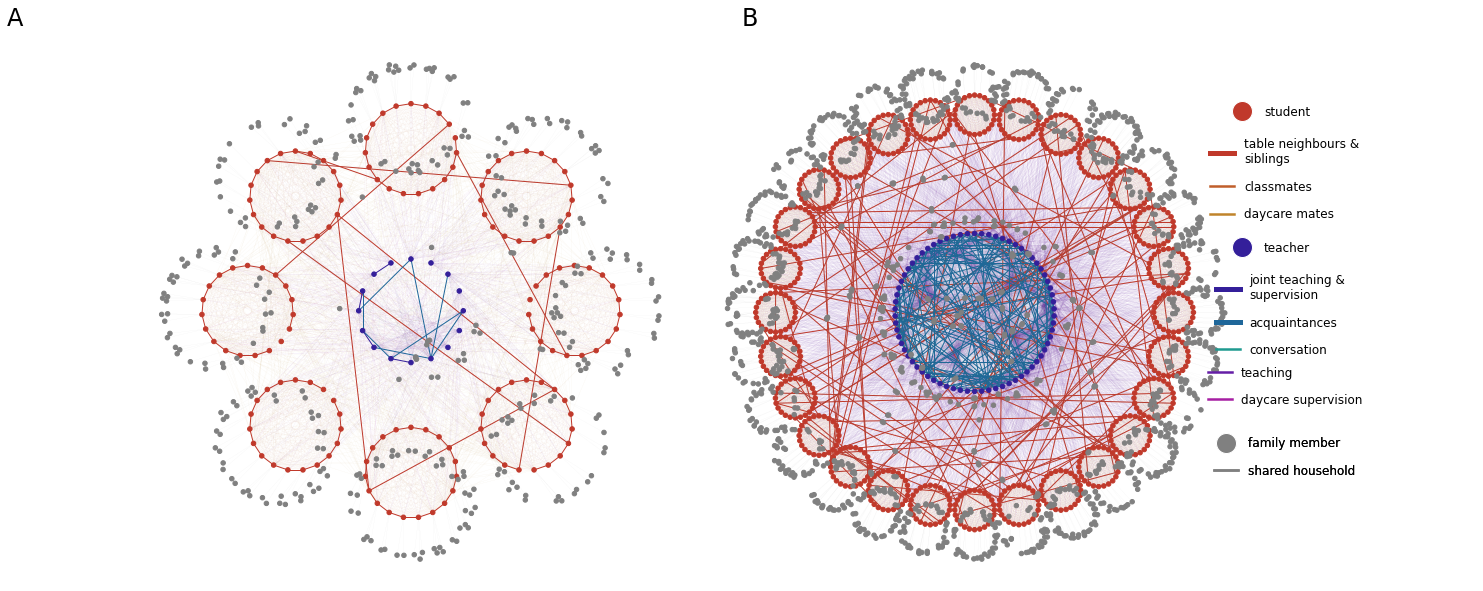

In [34]:
fig = plt.figure(constrained_layout=True, figsize=(24, 10))
gs = fig.add_gridspec(1, 12)
ax1 = fig.add_subplot(gs[0, 0:5])
ax2 = fig.add_subplot(gs[0, 5:10])
ax3 = fig.add_subplot(gs[0, 10:])
ax3.set_axis_off()

student_lts = ['siblings',
               'student_student_table_neighbour',
               'student_student_intra_class',
               'student_student_daycare']

ts_lts = ['teaching_teacher_student',
          'daycare_supervision_teacher_student']

teacher_lts = ['teacher_teacher_daycare_supervision',
               'teacher_teacher_long',
               'teacher_teacher_short']

family_lts = ['student_household', 'teacher_household']

### primary school with daycare ###
students = node_list_primary_dc[node_list_primary_dc['type'] == 'student']['ID'].values
teachers = node_list_primary_dc[node_list_primary_dc['type'] == 'teacher']['ID'].values
family_members = node_list_primary_dc[node_list_primary_dc['type'] == 'family_member']['ID'].values

node_color = [colors['student']] * len(students)
node_color.extend([colors['teacher']] * len(teachers))
node_color.extend([colors['family_member']] * len(family_members))

all_nodes = list(students)
all_nodes.extend(list(teachers))
all_nodes.extend(list(family_members))

ax = ax1
nx.draw(G_primary_dc, pos_primary_dc, node_size=20, ax=ax, width = 0,
        nodelist=all_nodes, node_color = node_color)

# student <-> student links
for lt in student_lts:
    edgelist = [(u, v) for u, v, e in G_primary_dc.edges(data=True) if e['link_type'] == lt]
    nx.draw_networkx_edges(G_primary_dc, pos_primary_dc, edgelist, ax=ax,
                    width=widths[lt], edge_color=colors[lt], label=labels[lt])

# teacher <-> student links
for lt in ts_lts:
    edgelist = [(u, v) for u, v, e in G_primary_dc.edges(data=True) if e['link_type'] == lt]
    nx.draw_networkx_edges(G_primary_dc, pos_primary_dc, edgelist, ax=ax, width=widths[lt],
                           edge_color=colors[lt], label=labels[lt])
    
    
# family links
lt = 'siblings'
edgelist = [(u, v) for u, v, e in G_primary_dc.edges(data=True) if \
                    e['contact_type'] == 'close' and \
                    G_primary_dc.nodes[u]['type'] == 'student' and \
                    G_primary_dc.nodes[v]['type'] == 'student']
nx.draw_networkx_edges(G_primary_dc, pos_primary_dc, edgelist, ax=ax, width=1,
                       edge_color=colors[lt], label=labels[lt])

for lt in teacher_lts:
    edgelist = [(u, v) for u, v, e in G_primary_dc.edges(data=True) if e['link_type'] == lt]
    nx.draw_networkx_edges(G_primary_dc, pos_primary_dc, edgelist, ax=ax, width=widths[lt],
                           edge_color=colors[lt], label=labels[lt])

# family member
for lt in family_lts:
    edgelist = [(u, v) for u, v, e in G_primary_dc.edges(data=True) if e['link_type'] == lt]
    nx.draw_networkx_edges(G_primary_dc, pos_primary_dc, edgelist, ax=ax, width=widths[lt],
                           edge_color=colors[lt], label=labels[lt])
    



### secondary school ###
students = node_list_secondary[node_list_secondary['type'] == 'student']['ID'].values
teachers = node_list_secondary[node_list_secondary['type'] == 'teacher']['ID'].values
family_members = node_list_secondary[node_list_secondary['type'] == 'family_member']['ID'].values

node_color = [colors['student']] * len(students)
node_color.extend([colors['teacher']] * len(teachers))
node_color.extend([colors['family_member']] * len(family_members))

all_nodes = list(students)
all_nodes.extend(list(teachers))
all_nodes.extend(list(family_members))

ax = ax2
nx.draw(G_secondary, pos_secondary, node_size=20, ax=ax, width=0,
        nodelist=all_nodes, node_color=node_color)

# teacher <-> student links
for lt in ts_lts:
    edgelist = [(u, v) for u, v, e in G_secondary.edges(data=True) if e['link_type'] == lt]
    nx.draw_networkx_edges(G_secondary, pos_secondary, edgelist, ax=ax, width=widths[lt],
                           edge_color=colors[lt], label=labels[lt])
    
ts_lines = [Line2D([0],[0], color=colors[lt], lw=w, label=labels[lt])\
                 for lt, w in zip(ts_lts, [2.5, 2.5])]
leg5 = ax.legend(handles = ts_lines, 
          labelspacing=labelspacing, loc='upper right', frameon=False,
          bbox_to_anchor=(1.226, 0.42), fontsize=legend_fontsize)


for lt in student_lts:
    edgelist = [(u, v) for u, v, e in G_secondary.edges(data=True) if e['link_type'] == lt]
    nx.draw_networkx_edges(G_secondary, pos_secondary, edgelist, ax=ax, width=widths[lt],
                           edge_color=colors[lt], label=labels[lt])

# family links
lt = 'siblings'
edgelist = [(u, v) for u, v, e in G_secondary.edges(data=True) if \
                    e['contact_type'] == 'close' and \
                    G_secondary.nodes[u]['type'] == 'student' and \
                    G_secondary.nodes[v]['type'] == 'student']
nx.draw_networkx_edges(G_secondary, pos_secondary, edgelist, ax=ax, width=1, 
                       edge_color=colors[lt], label=labels[lt])


legend_fontsize = 12
labelspacing = 1.2
# student <-> student link legend
student_marker = Line2D([0], [0], marker='o', color='w',
                      markerfacecolor=colors['student'], markersize=20,
                      label='student')

student_lines = [Line2D([0],[0], color=colors[lt], lw=w, label=labels[lt])\
                 for lt, w in zip(student_lts[1:], [5, 2.5, 2.5])]

leg1 = ax.legend(handles = [student_marker], 
          labelspacing=labelspacing, loc='upper right', frameon=False,
          bbox_to_anchor=(1.130, 0.9), fontsize=legend_fontsize)
leg2 = ax.legend(handles = student_lines, 
          labelspacing=labelspacing, loc='upper right', frameon=False,
          bbox_to_anchor=(1.220, 0.84), fontsize=legend_fontsize)

teacher_marker = Line2D([0], [0], marker='o', color='w',
                      markerfacecolor=colors['teacher'], markersize=20,
                      label='teacher')

teacher_lines = [Line2D([0],[0], color=colors[lt], lw=w, label=labels[lt])\
                 for lt, w in zip(teacher_lts, [5, 5, 2.5])]

for lt in teacher_lts:
    edgelist = [(u, v) for u, v, e in G_secondary.edges(data=True) if e['link_type'] == lt]
    nx.draw_networkx_edges(G_secondary, pos_secondary, edgelist, ax=ax, width=widths[lt],
                           edge_color=colors[lt], label=labels[lt])

leg3 = ax.legend(handles = [teacher_marker], 
          labelspacing=labelspacing, loc='upper right', frameon=False,
          bbox_to_anchor=(1.130, 0.65), fontsize=legend_fontsize)
leg4 = ax.legend(handles = teacher_lines, 
          labelspacing=labelspacing, loc='upper right', frameon=False,
          bbox_to_anchor=(1.195, 0.59), fontsize=legend_fontsize)

# family member
family_marker = Line2D([0], [0], marker='o', color='w',
                      markerfacecolor=colors['family_member'], markersize=20,
                      label='family member')

for lt in family_lts:
    edgelist = [(u, v) for u, v, e in G_secondary.edges(data=True) if e['link_type'] == lt]
    nx.draw_networkx_edges(G_secondary, pos_secondary, edgelist, ax=ax, width=widths[lt],
                           edge_color=colors[lt], label=labels[lt])
    
family_lines = [Line2D([0],[0], color=colors[lt], lw=w, label=labels[lt])\
                 for lt, w in zip(family_lts, [2.5])]
leg6 = ax.legend(handles = [family_marker] + family_lines,
          labelspacing=labelspacing, loc='upper right', frameon=False,
          bbox_to_anchor=(1.212, 0.29), fontsize=legend_fontsize)

for leg in [leg1, leg2, leg3, leg4, leg5, leg6]:
    ax.add_artist(leg)
    
fig.text(0.05, 0.9, 'A', fontsize=24)
fig.text(0.475, 0.9, 'B', fontsize=24)
plt.savefig(join(dst,'primary_dc_and_secondary.pdf'))
plt.savefig(join(dst,'primary_dc_and_secondary.svg'))